In [ ]:
import numpy as np
from itertools import product
import scipy.special
import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax.scipy as jsp
from jax import grad, value_and_grad

: 

In [57]:
npaths = 100000
nsteps = 52 

T = 1
dt = 1.0/nsteps 
s = int(nsteps * T) 
t = np.linspace(T/s,T,s)

strike = 100
#spot = 100.0

H = 0.1
eta = 1 
rho = -.3 
xi = 0.235**2

In [58]:
def sim_paths():

    v, u = np.zeros(pow(s,2)), np.zeros(pow(s,2))

    k = 0
    for i in product(t, t):
        v[k], u[k] = i
        k = k + 1

    # Matrix keeping track of which minimum time index in each entry
    index_matrix = np.reshape(np.minimum(v,u),(s,s))

    # Used to find E[WW], see Gatheral
    def G(H, x): 
        F = scipy.special.hyp2f1(1.0,0.5-H,1.5+H,1.0/x)
        return (2*H*(x**(H-0.5))*scipy.special.gamma(0.5+H)*F)/scipy.special.gamma(H+1.5)

    # Initialize E[WW] and E[WZ]
    WW = np.zeros((s,s))
    WZ = np.zeros((s,s))

    # Correlation of Browninan motion with itself
    ZZ = index_matrix

    # Used to find E[WZ], see Gatheral
    D = np.sqrt(2.0*H)/(H+0.5)

    # Construction E[WW] and E[WZ]
    i = 0
    for v in t:
        j = 0
        for u in t:
            if i == j:
                WW[i,j] = u**(2.0*H)
            if i > j:
                x = v/u
                WW[i,j] = u**(2.0*H)*G(H,x)
            if i < j:
                WW[i,j] = 0
            WZ[i,j] = D * (v**(H+0.5)-(v-np.minimum(u,v))**(H+0.5))
            j += 1
        i += 1

    # Utilizing that E[WW] is symmetric 
    WW = WW + WW.T - np.diag(WW.diagonal())

    # Creating covariance matrix for (W,Z)~N(0,Sigma)
    cov = np.block([[WW, WZ],[WZ.T, ZZ]]) # = Sigma

    mean = np.zeros(s*2)

    # Simulating the specified number of paths by drawing 
    # from the joint distribution of W and Z
    paths = np.random.multivariate_normal(mean=mean,cov=cov, size=npaths)

    ### Slower, but maybe more illustrating way of achieving the above ###

    #A = scipy.linalg.cholesky(cov, lower=True)
    #normal = np.random.randn(steps*2,npaths)
    #paths = np.matmul(A, normal)

    return paths

In [59]:
paths = sim_paths()
volterra, W = np.zeros((npaths,s+1)), np.zeros((npaths,s+1)) 
volterra[:,0] = 0; volterra[:,1:] = paths[:,:s]
W[:,0] = 0; W[:,1:] = paths[:,s:]
dW = np.diff(W, axis = 1)

t = np.linspace(0,T,s+1); S0 = 1
V = xi * np.exp(eta * volterra-0.5 * eta**2 * t**(2 * (H-0.5) + 1))
increments = np.sqrt(V[:,:-1]) * dW - 0.5 * V[:,:-1] * dt
integral = np.cumsum(increments, axis = 1)

S = np.zeros_like(V)
S[:,0] = S0
S[:,1:] = S0 * np.exp(integral)

In [60]:
def price(spot):
    S = jnp.empty(shape=(npaths,nsteps+1))
    S = S.at[:,0].set(spot)

    for i in range(nsteps):
        inc = jnp.exp(jnp.sqrt(V[:,i]) * dW[:,i] - 0.5 * V[:,i] * dt)
        S = S.at[:,i+1].set(S[:,i]*inc)

    return jnp.sum(jnp.where(S[:,i+1]-strike<0,0,S[:,i+1]-strike))/npaths

In [61]:
spots = np.linspace(35, 165, 100)

In [63]:
p = []
d = []

for spot in spots:
    C, delta = value_and_grad(price, argnums=0)(spot)
    p.append(C)
    d.append(delta)

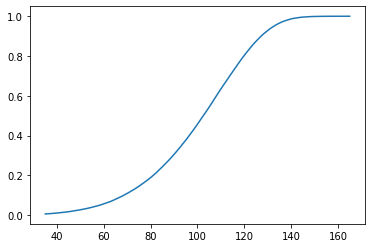

In [66]:
import matplotlib.pyplot as plt

plt.plot(spots, d)

In [ ]:
#plot, axes = plt.subplots()
#axes.plot(-2*np.mean(np.log(S), axis=0), 'r')
#axes.plot(0.235**2 * t, 'g')

In [ ]:
#plt.plot(np.mean(S, axis=0))